<a href="https://colab.research.google.com/github/kundajelab/dragonn/blob/master/tutorials/Tutorial%201%20-%20Exploring%20model%20architectures%20for%20a%20homotypic%20motif%20density%20simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to train your DragoNN tutorial 2: 
## Interpreting features induced by CNN's 


This tutorial will take 1 hour if executed on a GPU.

## Outline<a name='outline'>
<ol>
    <li><a href=#1>How to use this tutorial</a></li>
    <li><a href=#2>Review of patterns in transcription factor binding sites</a></li>
    <li><a href=#3>Learning to localize homotypic motif density</a></li>
    <li><a href=#4>Simulate training data with simdna</a></li>  
    <li><a href=#4.5>Running dragonn on your own data: starting with FASTA files</a></li>
    <li><a href=#5>Defining CNN architecture</a></li>
    <li><a href=#9>Multi-layer model</a></li>
    <li><a href=#8>Model Interpretation</a></li>    
    <li><a href=#10>Regularized multi-layer model</a></li>
    <li><a href=#12>Further exploration</a></li>    
    <li><a href=#13>Using DragoNN command-line interface</a></li>
</ol>
Github issues on the dragonn repository with feedback, questions, and discussion are always welcome.

 

## How to use this tutorial<a name='1'>
<a href=#outline>Home</a>

This tutorial utilizes a Jupyter/IPython Notebook - an interactive computational enviroment that combines live code, visualizations, and explanatory text. The notebook is organized into a series of cells. You can run the next cell by cliking the play button:
![play button](https://github.com/kundajelab/dragonn/blob/cshl/paper_supplement/primer_tutorial_images/play_button.png?raw=1)
You can also run all cells in a series by clicking "run all" in the Cell drop-down menu:
![play all button](https://github.com/kundajelab/dragonn/blob/cshl/paper_supplement/primer_tutorial_images/play_all_button.png?raw=1)
Half of the cells in this tutorial contain code, the other half contain visualizations and explanatory text. Code, visualizations, and text in cells can be modified - you are encouraged to modify the code as you advance through the tutorial. You can inspect the implementation of a function used in a cell by following these steps:
![inspecting code](https://github.com/kundajelab/dragonn/blob/cshl/paper_supplement/primer_tutorial_images/inspecting_code.png?raw=1)


In [1]:
#uncomment the lines below if you are running this tutorial from Google Colab 
# RESTART NOTEBOOK AFTER RUNNING THIS
#!pip install git+https://github.com/kundajelab/dragonn.git@cshl
#!pip install git+https://github.com/kundajelab/shap.git

In [1]:
# Making sure our results are reproducible
from numpy.random import seed
seed(1234)
from tensorflow.random import set_seed
set_seed(1234)
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

We start by loading dragonn's tutorial utilities and reviewing properties of regulatory sequence that transcription factors bind.

In [29]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Key properties of regulatory DNA sequences <a name='2'>
<a href=#outline>Home</a>

![sequence properties 1](https://github.com/kundajelab/dragonn/blob/master/paper_supplement/primer_tutorial_images/sequence_properties_1.jpg?raw=1)
![sequence properties 2](https://github.com/kundajelab/dragonn/blob/master/paper_supplement/primer_tutorial_images/sequence_properties_2.jpg?raw=1)

## Learning to localize homotypic motif density <a name='3'>
<a href=#outline>Home</a>

In this tutorial we will learn how to localize a homotypic motif cluster. We will simulate a positive set of sequences with multiple instances of a motif in the center and a negative set of sequences with multiple motif instances positioned anywhere in the sequence:
![homotypic motif density localization](https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/homotypic_motif_density_localization.jpg?raw=1)
We will then train a binary classification model to classify the simulated sequences. To solve this task, the model will need to learn the motif pattern and whether instances of that pattern are present in the central part of the sequence.

![classification task](https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/homotypic_motif_density_localization_task.jpg?raw=1)

We start by getting the simulation data.

## Getting simulation data <a name='4'>
<a href=#outline>Home</a>


DragoNN provides a set of simulation functions. We will use the **simulate_motif_density_localization** function to simulate homotypic motif density localization. First, we obtain documentation for the simulation parameters.

In [3]:
from dragonn.simulations import * 

In [4]:
print_simulation_info("simulate_motif_density_localization")


    Simulates two classes of seqeuences:
        - Positive class sequences with multiple motif instances
          in center of the sequence.
        - Negative class sequences with multiple motif instances
          anywhere in the sequence.
    The number of motif instances is uniformly sampled
    between minimum and maximum motif counts.

    Parameters
    ----------
    motif_name : str
        encode motif name
    seq_length : int
        length of sequence
    center_size : int
        length of central part of the sequence where motifs can be positioned
    min_motif_counts : int
        minimum number of motif instances
    max_motif_counts : int
        maximum number of motif instances
    num_pos : int
        number of positive class sequences
    num_neg : int
        number of negative class sequences
    GC_fraction : float
        GC fraction in background sequence

    Returns
    -------
    sequence_arr : 1darray
        Contains sequence strings.
    y : 1darra

Next, we define parameters for a TAL1 motif density localization in 1500bp long sequence, with 0.4 GC fraction, and 2-4 instances of the motif in the central 150bp for the positive sequences. We simulate a total of 3000 positive and 3000 negative sequences.

In [5]:
motif_density_localization_simulation_parameters = {
    "motif_name": "TAL1_known4",
    "seq_length": 1500,
    "center_size": 150,
    "min_motif_counts": 2,
    "max_motif_counts": 4, 
    "num_pos": 3000,
    "num_neg": 3000,
    "GC_fraction": 0.4}

We get the simulation data by calling the **get_simulation_data** function with the simulation name and the simulation parameters as inputs. 1000 sequences are held out for a test set, 1000 sequences for a validation set, and the remaining 4000 sequences are in the training set.

In [6]:
simulation_data = get_simulation_data("simulate_motif_density_localization",
                                      motif_density_localization_simulation_parameters,
                                      validation_set_size=1000, test_set_size=1000)

simulation_data provides training, validation, and test sets of input sequences X and sequence labels y. The inputs X are matrices with a one-hot-encoding of the sequences:
<img src="https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/one_hot_encoding.png?raw=1" width="500">

Here are the first 10bp of a sequence in our training data:

In [8]:
simulation_data.X_train[0, :, :10, :]

array([[[1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0]]])

We can convert this one-hot-encoded matrix back into a DNA string:

In [9]:
simulation_data.X_train.shape

(4000, 1, 1500, 4)

In [10]:
from dragonn.utils import *
get_sequence_strings(simulation_data.X_train)[0][0:10]

'AAGTGCAAAA'

Let's examine the shape of training, validation, and test matrices: 

In [11]:
print(simulation_data.X_train.shape)
print(simulation_data.y_train.shape)

(4000, 1, 1500, 4)
(4000, 1)


In [12]:
print(simulation_data.X_valid.shape)
print(simulation_data.y_valid.shape)

(1000, 1, 1500, 4)
(1000, 1)


In [13]:
print(simulation_data.X_test.shape)
print(simulation_data.y_test.shape)

(1000, 1, 1500, 4)
(1000, 1)


## Running dragonn on your own data: starting with FASTA files <a name='4.5'>
<a href=#outline>Home</a>

If you are running Dragonn on your own data, you can provide data in FASTA sequence format. We recommend generating 6 fasta files for model training: 
* Training positives 
* Training negatives 
* Validation positives 
* Validation negatives 
* Test positives 
* Test negatives 

To indicate how this could be done, we export the one-hot-encoded matrices from **simulation_data** to a FASTA file, and then show how this fasta file could be loaded back to a one-hot-encoded matrix.

In [14]:
from dragonn.utils import fasta_from_onehot

#get the indices of positive and negative sequences in the training, validation, and test sets 
train_pos=np.nonzero(simulation_data.y_train==True)
train_neg=np.nonzero(simulation_data.y_train==False)
valid_pos=np.nonzero(simulation_data.y_valid==True)
valid_neg=np.nonzero(simulation_data.y_valid==False)
test_pos=np.nonzero(simulation_data.y_test==True)
test_neg=np.nonzero(simulation_data.y_test==False)

#Generate fasta files
fasta_from_onehot(np.expand_dims(simulation_data.X_train[train_pos],axis=1),"X.train.pos.fasta")
fasta_from_onehot(np.expand_dims(simulation_data.X_valid[valid_pos],axis=1),"X.valid.pos.fasta")
fasta_from_onehot(np.expand_dims(simulation_data.X_test[test_pos],axis=1),"X.test.pos.fasta")

fasta_from_onehot(np.expand_dims(simulation_data.X_train[train_neg],axis=1),"X.train.neg.fasta")
fasta_from_onehot(np.expand_dims(simulation_data.X_valid[valid_neg],axis=1),"X.valid.neg.fasta")
fasta_from_onehot(np.expand_dims(simulation_data.X_test[test_neg],axis=1),"X.test.neg.fasta")

Let's examine "X.train.pos.fasta" to verify that it's in the standard FASTA format. 

In [15]:
!zcat X.train.pos.fasta | head

>0
AAGTGCAAAAAACAGACAAGATGGGTACAACGTTATCCAACGTGAGTAAATAGCTGATGAAACAGGCAGCTTTTCTCTGAATCAGAAATATACAGGTTTCCGCACCTATTTGTATAGAAGCGAACGTTCTGAGGTATGAATACGATGATAATGACTAACAGAAGTGTTTGCAGAGCGGGTGATTCCGCGTATTTCGCCAACAAGATAACATCAAGCAAATCAAGTTTACCGCTGCTGAGTGATATATAAAGGGATTCACTTAATCGTTTGTATAATTTGAGAGCAGTTATTCTACTACAACTGATTCATTACCTAAACTATGTTTATATCATCCCCAGCAAATTTATTCTTTGTAAAGTAATTAAAAAATACTTCACCCACTAATCTATATATTTTATGAAATCCATGATGTTCCTAATGTGTCAGACCCGGATCTCACACGGATGAGAGAGTTGGACACTGTTGATGCATTGATACAGGGAAAGTGTAAGACTATCGAAGAGCCTTCCAATGTCAGATTTAATCGTACAATTGAATTGTCTTATAACTCATGAGCCTTTTCCAAGAGAGTCTCATCGGCCATACTTTGATATCGTGTTGTAATTCACAAAGCTAGAAATAGGGGGATGTAAGCTCCCGATATTCTTATCCTAATAGGCTTAGTCAGACCAGTCGAACAGTCCAGCTGCCTACGCGTACTCATAGAGTCCTGGCCACCTGCTACATGCGTGGGCAAGCTATCACGGCAAGGTCCTGTATCGCCACCTGCTCGGCTTCCCTGAAGATGAAGATGCTGGTCAATGAAAAGTGCTATGATAGCATACGAACCTGTATTTAATCGATCTAACCATGTGTGAGTTCATTAACTCTTGGGCATATGTTTTCTTGATTCCTGCTTGTGCTTTCTGTTCTTTGAAAACGTATGTTCTTCTTATCTATGACTCCTTAGCAAAACATAATGATACACCTCTTAATACGCTAAAATAGATATGTAGTG

We can then load fasta format data to generate training, validation, and test splits for our models:

In [16]:
from dragonn.utils import encode_fasta_sequences
X_train_pos=encode_fasta_sequences("X.train.pos.fasta")
X_train_neg=encode_fasta_sequences("X.train.neg.fasta")
X_valid_pos=encode_fasta_sequences("X.valid.pos.fasta")
X_valid_neg=encode_fasta_sequences("X.valid.neg.fasta")
X_test_pos=encode_fasta_sequences("X.test.pos.fasta")
X_test_neg=encode_fasta_sequences("X.test.neg.fasta")

X_train=np.concatenate((X_train_pos,X_train_neg),axis=0)
X_valid=np.concatenate((X_valid_pos,X_valid_neg),axis=0)
X_test=np.concatenate((X_test_pos,X_test_neg),axis=0)


In [17]:
y_train=np.concatenate((np.ones(X_train_pos.shape[0]),
                        np.zeros(X_train_neg.shape[0])))
y_valid=np.concatenate((np.ones(X_valid_pos.shape[0]),
                        np.zeros(X_valid_neg.shape[0])))
y_test=np.concatenate((np.ones(X_test_pos.shape[0]),
                        np.zeros(X_test_neg.shape[0])))


Now, having read in the FASTA files, converted them to one-hot-encoded matrices, and defined label vectors, we are ready to train our model. 

# Defining the convolutional neural network model architecture  <a name='5'>
<a href=#outline>Home</a>

A locally connected linear unit in a CNN model can represent a PSSM (part a). A sequence PSSM score is obtained by multiplying the PSSM across the sequence, thresholding the PSSM scores, and taking the max (part b). A PSSM score can also be computed by a CNN model with tiled, locally connected linear units, amounting to a convolutional layer with a single convolutional filter representing the PSSM, followed by ReLU thresholding and maxpooling (part c).
![dragonn vs pssm](https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/dragonn_and_pssm.jpg?raw=1)
By utilizing multiple convolutional layers with multiple convolutional filters, CNN's can represent a wide range of sequence features in a compositional fashion:
![dragonn model figure](https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/dragonn_model_figure.jpg?raw=1)

We will use the deep learning library [keras](http://keras.io/) with the [TensorFlow](https://github.com/tensorflow/tensorflow) backend to generate and train the CNN models. 

In [18]:
#To prepare for model training, we import the necessary functions and submodules from keras
from keras.models import Sequential
from keras.layers import Dropout, Reshape, Dense, Activation, Flatten,Conv2D, MaxPooling2D,BatchNormalization
# from keras.layers.convolutional import Conv2D, MaxPooling2D
# from keras.optimizers import Adadelta, SGD, RMSprop;
import keras.losses;
from keras.constraints import maxnorm;
# from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, History
from keras import backend as K 
K.set_image_data_format('channels_last')


# A multi-layer DragoNN model <a name='9'>

<a href=#outline>Home</a> 

Next, we train a 3 layer model for this task. Will it outperform the single layer model and to what extent will it overfit?

In [25]:
#Define the model architecture in keras
multi_layer_keras_model=Sequential() 
multi_layer_keras_model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=simulation_data.X_train.shape[1::]))
multi_layer_keras_model.add(Activation('relu'))

multi_layer_keras_model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=simulation_data.X_train.shape[1::]))
multi_layer_keras_model.add(Activation('relu'))

multi_layer_keras_model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=simulation_data.X_train.shape[1::]))
multi_layer_keras_model.add(Activation('relu'))
multi_layer_keras_model.add(MaxPooling2D(pool_size=(1,35)))


multi_layer_keras_model.add(Flatten())
multi_layer_keras_model.add(Dense(1))
multi_layer_keras_model.add(Activation("sigmoid"))

##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
multi_layer_keras_model.compile(optimizer='adam',
                               loss='binary_crossentropy')

multi_layer_keras_model.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 1, 1491, 15)       615       
                                                                 
 activation_4 (Activation)   (None, 1, 1491, 15)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1482, 15)       2265      
                                                                 
 activation_5 (Activation)   (None, 1, 1482, 15)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 1473, 15)       2265      
                                                                 
 activation_6 (Activation)   (None, 1, 1473, 15)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 42, 15)       

We train the model for 150 epochs, with an early stopping criterion -- if the loss on the validation set does not improve for five consecutive epochs, the training is halted. In each epoch, the one_filter_dragonn performed a complete pass over the training data, and updated its parameters to minimize the loss, which quantifies the error in the model predictions. After each epoch, the performance metrics for the one_filter_dragonn on the validation data were stored. 

The performance metrics include balanced accuracy, area under the receiver-operating curve ([auROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)), are under the precision-recall curve ([auPRC](https://en.wikipedia.org/wiki/Precision_and_recall)), and recall for multiple false discovery rates  (Recall at [FDR](https://en.wikipedia.org/wiki/False_discovery_rate)).

In [20]:
from dragonn.callbacks import * 
#We define a custom callback to print training and validation metrics while training. 
metrics_callback=MetricsCallback(train_data=(simulation_data.X_train,simulation_data.y_train),
                                 validation_data=(simulation_data.X_valid,simulation_data.y_valid))



In [40]:
## use the keras fit function to train the model for 150 epochs with early stopping after 3 epochs 
history_multi_layer=multi_layer_keras_model.fit(x=simulation_data.X_train,
                                  y=simulation_data.y_train,
                                  batch_size=128,
                                  epochs=150,
                                  verbose=1,
                                  callbacks=[metrics_callback,
                                      EarlyStopping(patience=3,restore_best_weights=True)],
                                  validation_data=(simulation_data.X_valid,
                                                   simulation_data.y_valid))



Train on 4000 samples, validate on 1000 samples
Epoch 1/150
3968/4000 [============================>.] - ETA: 0s - loss: 0.6958Training Data:
Loss: 0.6865	Balanced Accuracy: 53.74%	 auROC: 0.623	 auPRC Careful: 0.603	 auPRC Trapezoidal: 0.603
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|1.9%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.6947	Balanced Accuracy: 52.68%	 auROC: 0.543	 auPRC Careful: 0.574	 auPRC Trapezoidal: 0.573
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 528	 Num Negatives: 472
4000/4000 [==============================] - 4s 1ms/sample - loss: 0.6958 - val_loss: 0.6947
Epoch 2/150
3968/4000 [============================>.] - ETA: 0s - loss: 0.6837Training Data:
Loss: 0.6781	Balanced Accuracy: 50.44%	 auROC: 0.757	 auPRC Careful: 0.735	 auPRC Trapezoidal: 0.735
	Recall at 5%|10%|20% FDR: 0.8%|3.5%|30.6%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.6966	Balanced Accuracy: 50.38%	 auROC: 0.642	 auPRC Careful: 0.673	 auPRC T

### Evaluate the model on the held-out test set 

In [41]:
## Use the keras predict function to get model predictions on held-out test set. 
test_predictions=multi_layer_keras_model.predict(simulation_data.X_test)
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(simulation_data.y_test,test_predictions))

Loss: 0.0821	Balanced Accuracy: 97.48%	 auROC: 0.995	 auPRC Careful: 0.994	 auPRC Trapezoidal: 0.994
	Recall at 5%|10%|20% FDR: 99.4%|99.6%|100.0%	 Num Positives: 515	 Num Negatives: 485


### Visualize the model's performance

We can see that the validation loss is not decreasing and the auROC metric is not decreasing, which indicates this model is not learning. A simple plot of the learning curve, showing the loss function on the training and validation data over the course of training, demonstrates this visually:

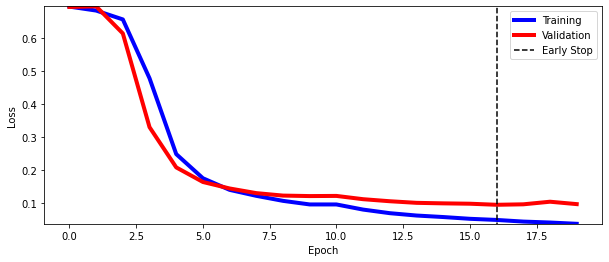

In [43]:
%matplotlib inline
#import functions foro visualization of data 
from dragonn.vis import *
## Visualize the model's performance 
plot_learning_curve(history_multi_layer)


This model performs slightly better than the single layer model but it overfits more. We will try to address that with dropout regularization.

We export the new model to hdf5 to allow for subsequent interpretation with Interpretation. 

In [46]:
multi_layer_keras_model.save("tut1_multi_layers_keras_model.hdf5")



We can now load the saved model for use in other applications or for further fine-tuning:

In [26]:
from keras.models import load_model
multi_layer_keras_model=load_model("tut1_multi_layers_keras_model.hdf5")

Plotting simulation motifs...


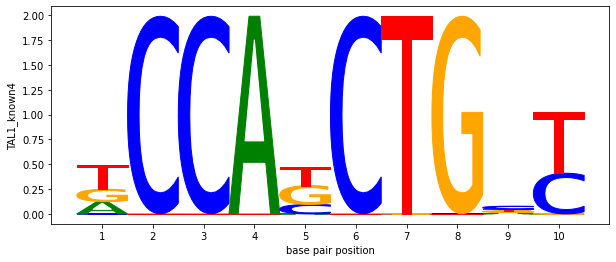

Visualizing convolutional sequence filters in SequenceDNN...


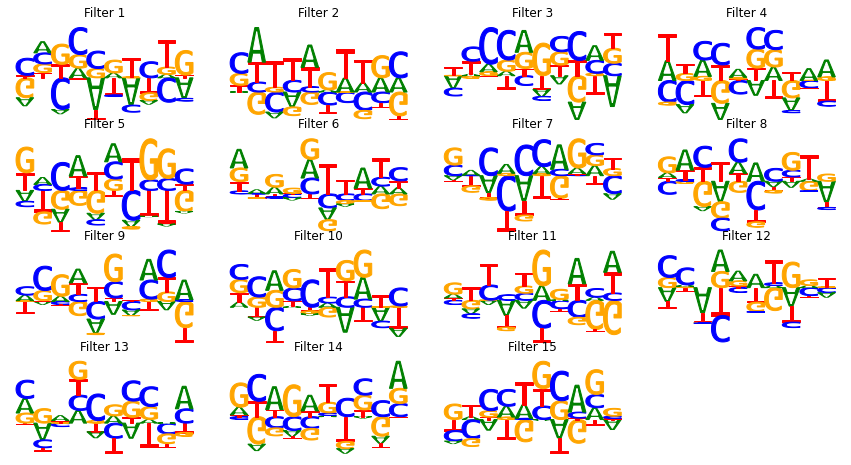

In [50]:
## Visualize the motifs learned by the model
%matplotlib inline
plot_filters(multi_layer_keras_model, simulation_data)

# Model Interpretation <a name='8'>
<a href=#outline>Home</a>


As you can see, the filters/model parameters are difficult to be interepreted directly. However, there are alternative approaches of interepreting sequences.

Let's examine a positive and negative example from our simulation data:

In [23]:
#get the indices of the first positive and negative examples in the validation data split
pos_indx=np.flatnonzero(simulation_data.y_valid==1)[0]
print(pos_indx)
pos_X=simulation_data.X_valid[pos_indx:pos_indx+1]

neg_indx=np.flatnonzero(simulation_data.y_valid==0)[10]
print(neg_indx)
neg_X=simulation_data.X_valid[neg_indx:neg_indx+1]

2
14


### Motif Scores

In [52]:
from dragonn.utils import * 
pos_motif_scores=get_motif_scores(pos_X,simulation_data.motif_names,return_positions=True)
neg_motif_scores=get_motif_scores(neg_X,simulation_data.motif_names,return_positions=True)

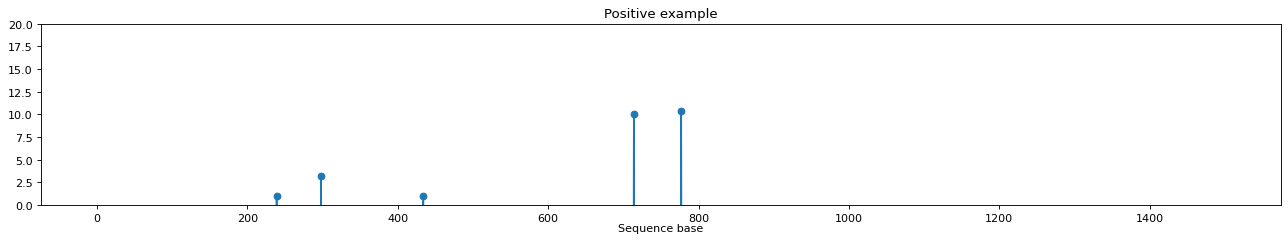

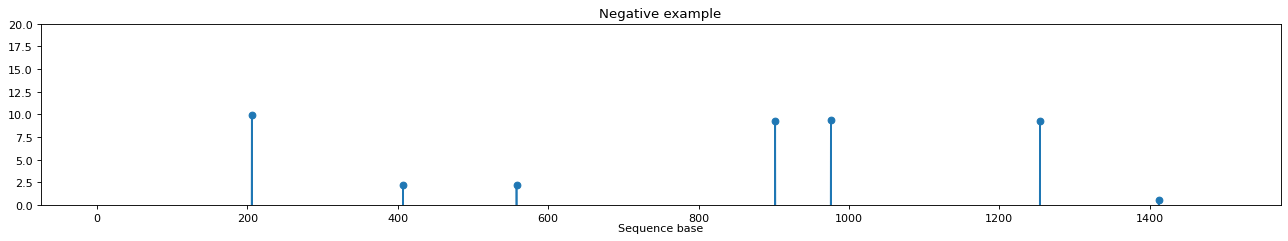

In [53]:
from dragonn.vis import * 
plot_motif_scores(pos_motif_scores,title="Positive example",ylim=(0,20))
plot_motif_scores(neg_motif_scores,title="Negative example",ylim=(0,20))

The motif scan yields a group of three high-scoring motif alignment positions at a fixed distance near the center of the sequence in the positive example. The spacing of the high-scoring motif alignments is random in the negative sequence. 

Note: If you find that your negative example is too close to the positive examle (i.e. the randomly spaced motifs happen to have a spacing close to the positive example, feel free to provide another index value to select a different negative). 

For example, you can change the code to select a negative example to the below: 


In [54]:
neg_indx=np.flatnonzero(simulation_data.y_valid==0)[10]
print(neg_indx)
neg_X=simulation_data.X_valid[neg_indx:neg_indx+1]

14


### *In silico* mutagenesis 

To determine how much each position in the input sequence contrinbutes to the model's prediction, we can perform saturation mutagenesis on the sequence. For each position in the input sequence, we introduce each of the four possible bases A, C, G, T and quantify the effect on the model's predictions.

*In silico* mutagenesis entails measuring the effect of a given base pair on the model's prediction of accessibility. The following algorithm is used: 

1. At each position in the input sequence, the reference allele is mutated to each of three possible alternate alleles, and the model predictions with the alternate alleles are obtained. 

2. The logit values for the reference allele are subtracted from the logit values for each of the 4 alleles. (This means that a difference of 0 will be obtained for the reference allele). We refer to these differences in logit at each position between the reference and alternate alleles as the ISM values. ISM values are computed in logit space to avoid any saturation effects from passing the logits through a sigmoid function. 

3. For each position, subtract the mean ISM value for that position from each of the 4 ISM values. 

4. Plot the 4xL heatmap of mean-normalized ISM values 

5. Identity the highest scoring (mean subtracted) allele at each position. 

In [55]:
pos_X.shape

(1, 1, 1500, 4)

In [56]:
from dragonn.interpret.ism import *
ism_pos=in_silico_mutagenesis(multi_layer_keras_model,pos_X,0)
ism_neg=in_silico_mutagenesis(multi_layer_keras_model,neg_X,0)

ISM: task:0 sample:0
ISM: task:0 sample:0


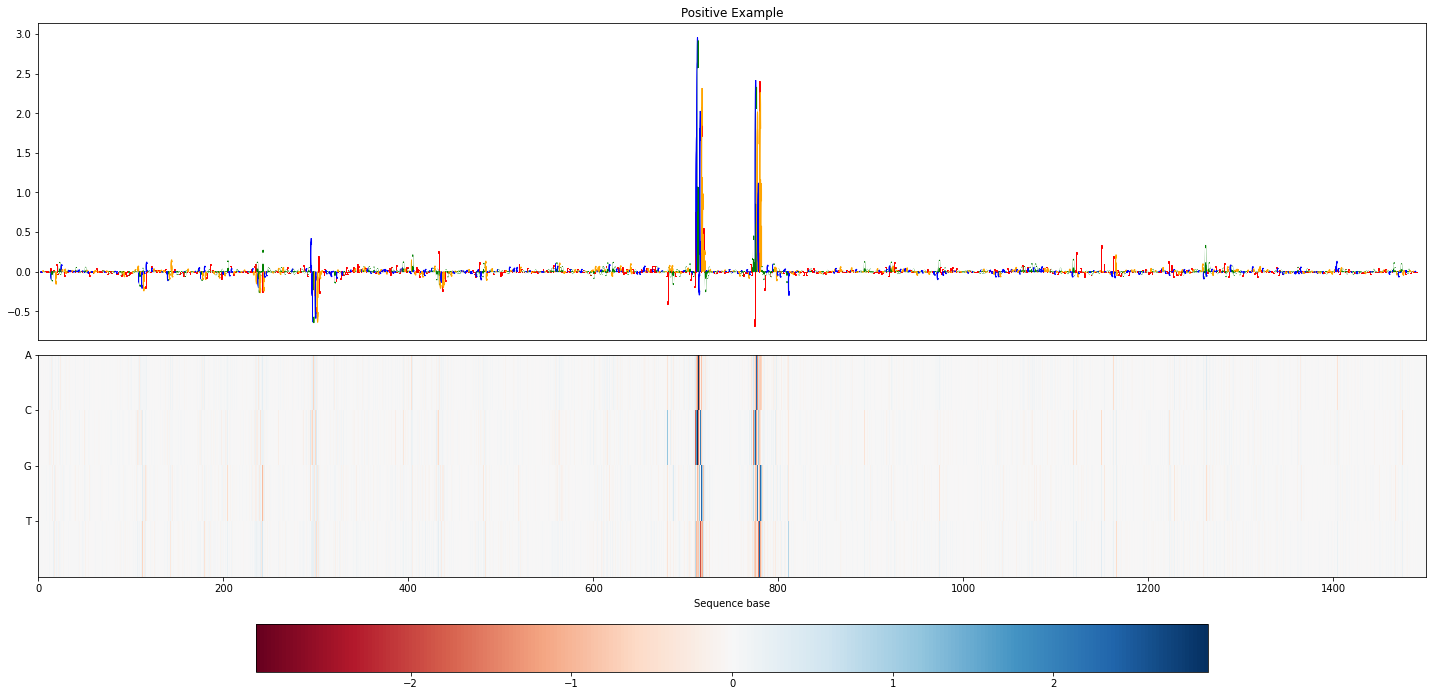

In [57]:
from dragonn.vis import * 
# create discrete colormap of ISM scores 
plot_ism(ism_pos,pos_X,title="Positive Example")


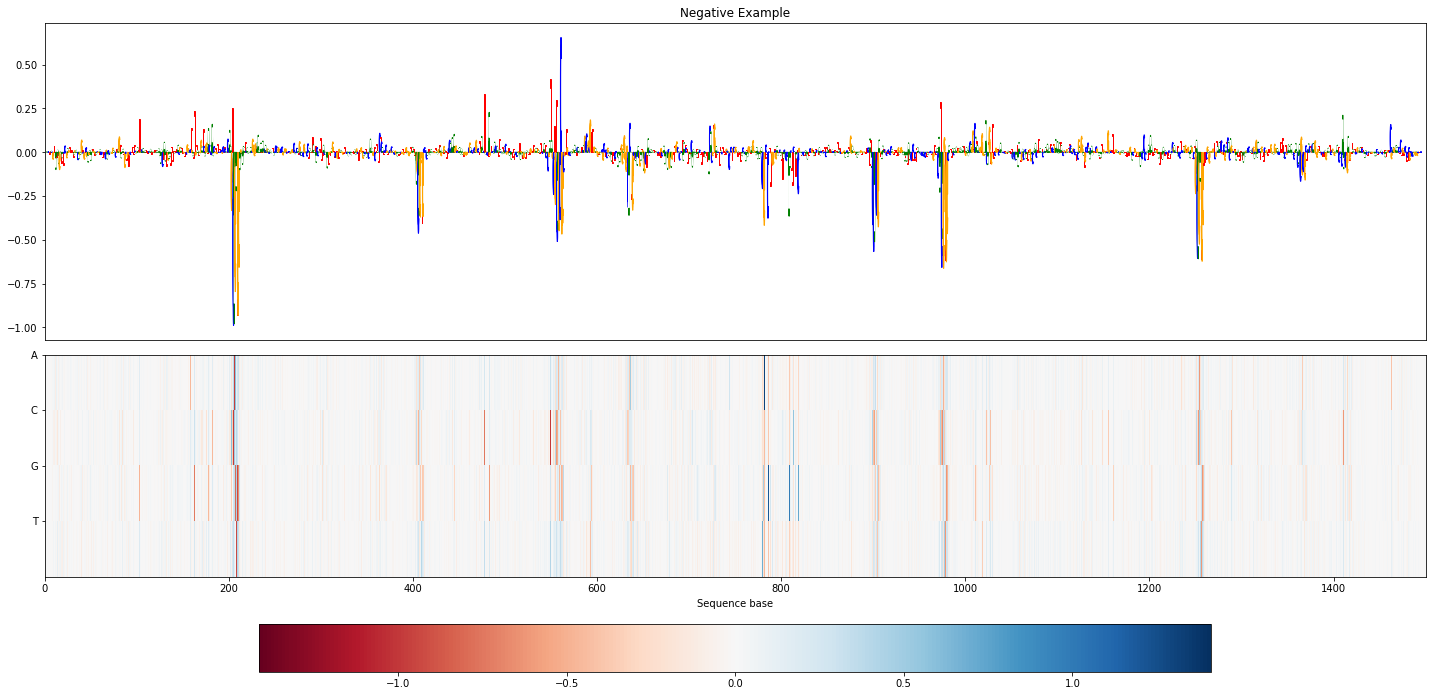

In [58]:
plot_ism(ism_neg,neg_X,title="Negative Example")

### Gradient x Input 

Consider a neural net being a function: $f(x_1, ..., x_N; w) = y$

One way to tell whether the input feature is important is to compute the gradient of the function with respect to (w.r.t.) model input: $\frac{\partial f}{\partial x_i}$

This approach is called saliency maps: "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps", by Karen Simonyan, Andrea Vedaldi and Andrew Zisserma https://arxiv.org/pdf/1312.6034.pdf

In genomics, we typically visualize only gradients for bases observed in the sequence (called input masked gradients or input*grad).

In [52]:
from dragonn.interpret.input_grad import * 
gradinput_pos=input_grad(multi_layer_keras_model,pos_X)
gradinput_neg=input_grad(multi_layer_keras_model,neg_X)

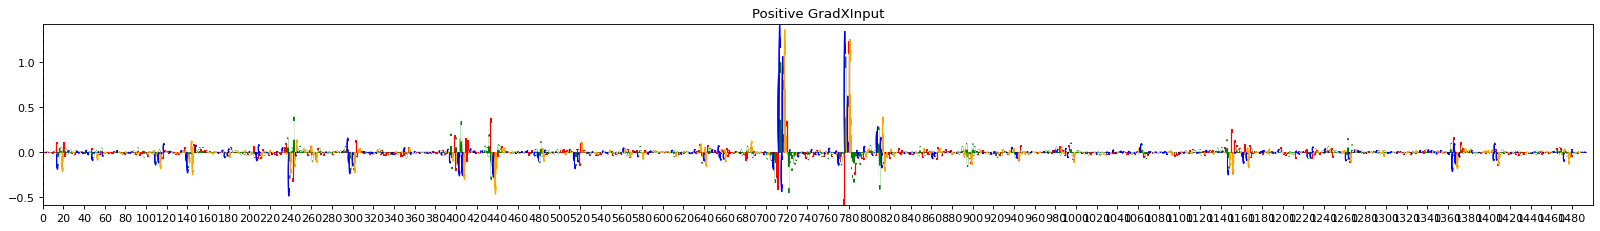

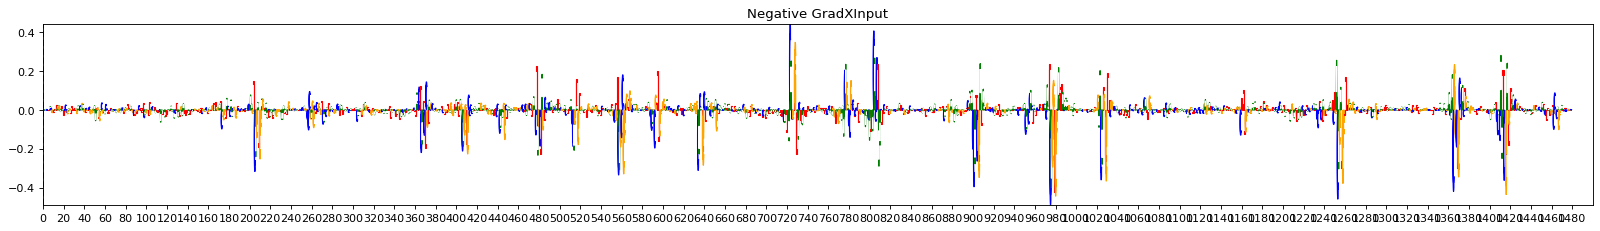

In [53]:
from dragonn.vis import plot_seq_importance
plot_seq_importance(gradinput_pos,pos_X,title="Positive GradXInput")
plot_seq_importance(gradinput_neg,neg_X,title="Negative GradXInput")


Let's zoom in to the center 150 bp of the sequence, where the simulated homotypic motif grammar is to be found. 

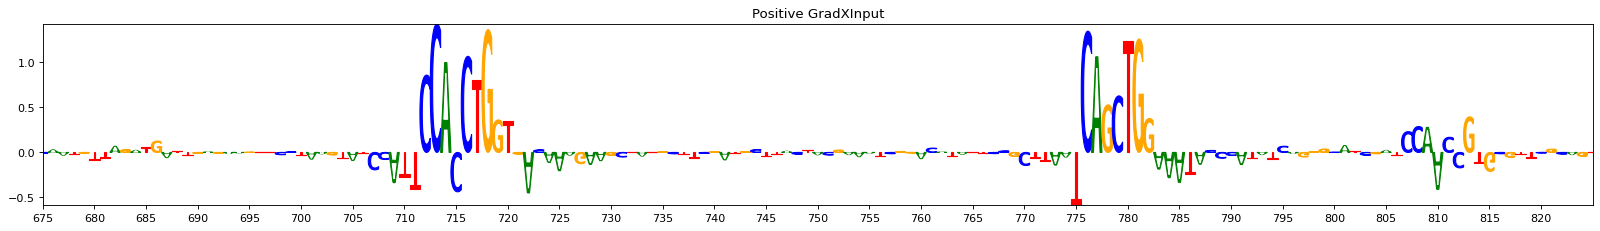

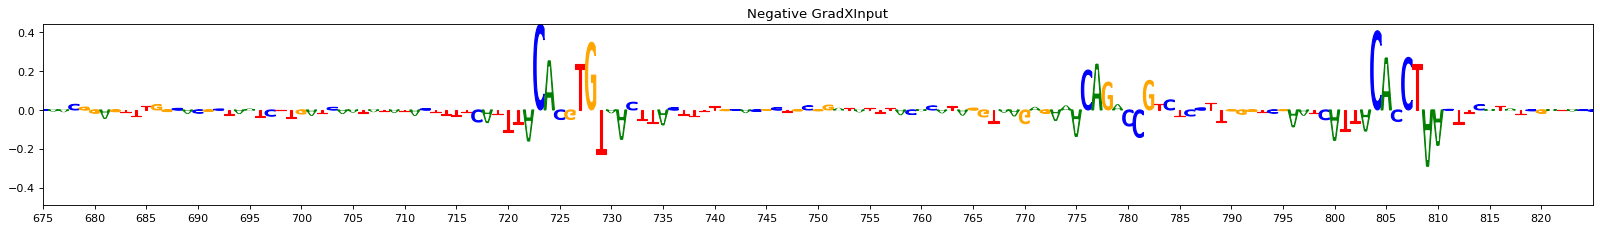

In [54]:
plot_seq_importance(gradinput_pos,pos_X,title="Positive GradXInput",xlim=(675,825))
plot_seq_importance(gradinput_neg,neg_X,title="Negative GradXInput",xlim=(675,825))

### DeepShap

[DeepShap](https://arxiv.org/pdf/1705.07874.pdf) computes the shapley value for every feature. The Shapley value is the average contribution of a feature to the prediction in different  possible combinations (coalitions). 

DeepShap can accept a custom reference. For our purposes, we provide a dinucleotide-shuffled reference. 

In [27]:
from dragonn.interpret.deepshap import * 
shap_scores_pos = deep_shap(multi_layer_keras_model,pos_X)
shap_scores_neg = deep_shap(multi_layer_keras_model,neg_X)

Done 0 examples of 1
Done 0 examples of 1


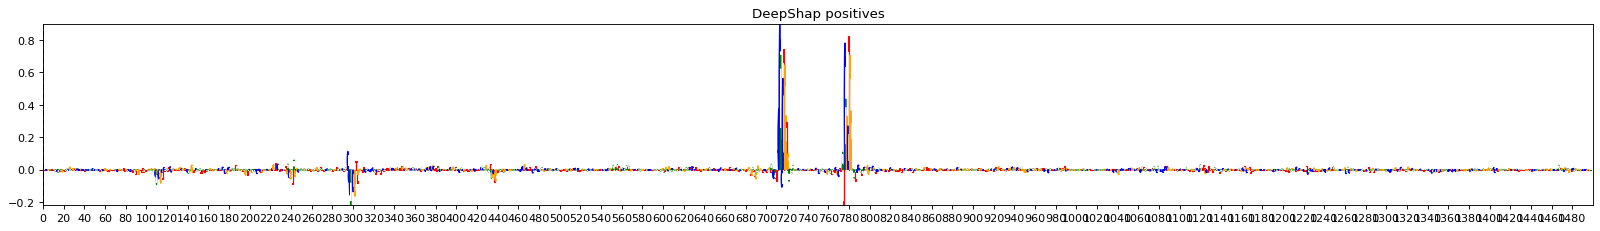

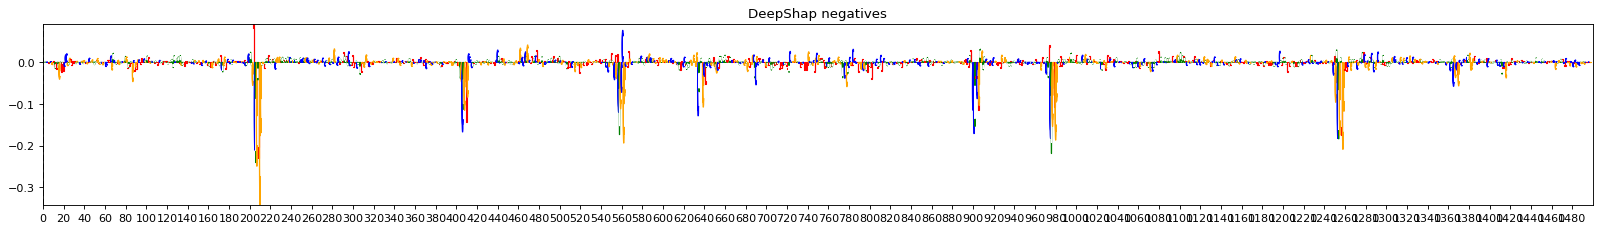

In [30]:
plot_seq_importance(shap_scores_pos,pos_X,title="DeepShap positives")
plot_seq_importance(shap_scores_neg,neg_X,title="DeepShap negatives") 

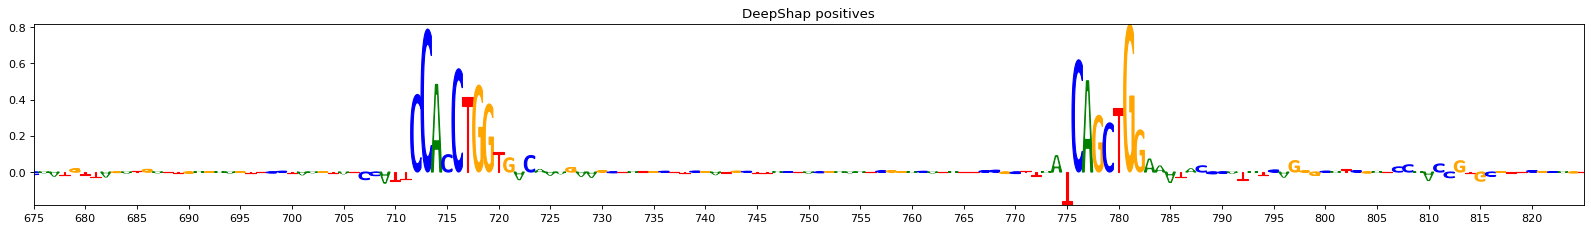

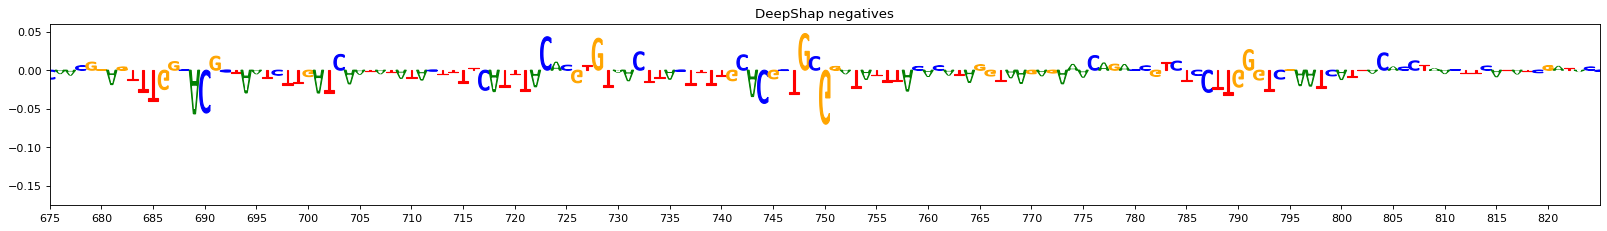

In [63]:
plot_seq_importance(shap_scores_pos,pos_X,title="DeepShap positives",xlim=(675,825))
plot_seq_importance(shap_scores_neg,neg_X,title="DeepShap negatives",xlim=(675,825))

# A regularized multi-layer DragoNN model <a name='10'>
    
<a href=#outline>Home</a> 
    
Next, we regularize the 3 layer using 0.2 dropout on every convolutional layer. Will dropout improve validation performance?

In [66]:
#Define the model architecture in keras

regularized_keras_model=Sequential() 
regularized_keras_model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=simulation_data.X_train.shape[1::]))
regularized_keras_model.add(Activation('relu'))
regularized_keras_model.add(Dropout(0.2))

regularized_keras_model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=simulation_data.X_train.shape[1::]))
regularized_keras_model.add(Activation('relu'))
regularized_keras_model.add(Dropout(0.2))

regularized_keras_model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=simulation_data.X_train.shape[1::]))
regularized_keras_model.add(Activation('relu'))
regularized_keras_model.add(Dropout(0.2))
regularized_keras_model.add(MaxPooling2D(pool_size=(1,35)))


regularized_keras_model.add(Flatten())
regularized_keras_model.add(Dense(1))
regularized_keras_model.add(Activation("sigmoid"))

##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
regularized_keras_model.compile(optimizer='adam',
                               loss='binary_crossentropy')

regularized_keras_model.summary() 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 1, 1491, 15)       615       
                                                                 
 activation_16 (Activation)  (None, 1, 1491, 15)       0         
                                                                 
 dropout_6 (Dropout)         (None, 1, 1491, 15)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 1, 1482, 15)       2265      
                                                                 
 activation_17 (Activation)  (None, 1, 1482, 15)       0         
                                                                 
 dropout_7 (Dropout)         (None, 1, 1482, 15)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 1, 1473, 15)      

In [67]:
## use the keras fit function to train the model for 150 epochs with early stopping after 3 epochs 
history_regularized=regularized_keras_model.fit(x=simulation_data.X_train,
                                  y=simulation_data.y_train,
                                  batch_size=128,
                                  epochs=150,
                                  verbose=1,
                                  callbacks=[metrics_callback,
                                            EarlyStopping(patience=3,restore_best_weights=True),],
                                  validation_data=(simulation_data.X_valid,
                                                   simulation_data.y_valid))


Train on 4000 samples, validate on 1000 samples
Epoch 1/150
3968/4000 [============================>.] - ETA: 0s - loss: 0.6976Training Data:
Loss: 0.6923	Balanced Accuracy: 50.45%	 auROC: 0.532	 auPRC Careful: 0.520	 auPRC Trapezoidal: 0.520
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.5%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.6975	Balanced Accuracy: 50.80%	 auROC: 0.504	 auPRC Careful: 0.536	 auPRC Trapezoidal: 0.534
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 528	 Num Negatives: 472
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.6978 - val_loss: 0.6975
Epoch 2/150
3968/4000 [============================>.] - ETA: 0s - loss: 0.6942Training Data:
Loss: 0.6924	Balanced Accuracy: 50.75%	 auROC: 0.567	 auPRC Careful: 0.549	 auPRC Trapezoidal: 0.549
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|0.4%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.6908	Balanced Accuracy: 50.41%	 auROC: 0.525	 auPRC Careful: 0.553	 auPRC Tr

3968/4000 [============================>.] - ETA: 0s - loss: 0.0739Training Data:
Loss: 0.0637	Balanced Accuracy: 97.65%	 auROC: 0.998	 auPRC Careful: 0.998	 auPRC Trapezoidal: 0.998
	Recall at 5%|10%|20% FDR: 99.9%|100.0%|100.0%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.0788	Balanced Accuracy: 97.30%	 auROC: 0.997	 auPRC Careful: 0.997	 auPRC Trapezoidal: 0.997
	Recall at 5%|10%|20% FDR: 99.2%|100.0%|100.0%	 Num Positives: 528	 Num Negatives: 472
4000/4000 [==============================] - 4s 1ms/sample - loss: 0.0735 - val_loss: 0.0788
Epoch 30/150
4000/4000 [==============================] - ETA: 0s - loss: 0.0674Training Data:
Loss: 0.0745	Balanced Accuracy: 97.09%	 auROC: 0.999	 auPRC Careful: 0.998	 auPRC Trapezoidal: 0.998
	Recall at 5%|10%|20% FDR: 99.9%|100.0%|100.0%	 Num Positives: 1957	 Num Negatives: 2043
Validation Data:
Loss: 0.0867	Balanced Accuracy: 96.76%	 auROC: 0.997	 auPRC Careful: 0.997	 auPRC Trapezoidal: 0.997
	Recall at 5%|10%|20% FDR: 

In [68]:
## Use the keras predict function to get model predictions on held-out test set. 
test_predictions=regularized_keras_model.predict(simulation_data.X_test)
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(simulation_data.y_test,test_predictions))

Loss: 0.0570	Balanced Accuracy: 98.15%	 auROC: 0.999	 auPRC Careful: 0.999	 auPRC Trapezoidal: 0.999
	Recall at 5%|10%|20% FDR: 99.8%|100.0%|100.0%	 Num Positives: 515	 Num Negatives: 485


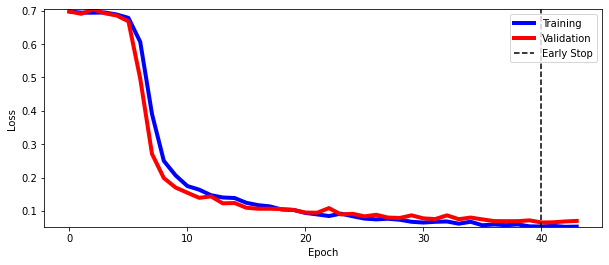

In [69]:
## Visualize the model's performance 
plot_learning_curve(history_regularized)

### Interpreting regularized, multi-layer model 

In [74]:
regularized_keras_model.save("TAL1.Simulation.Regularized.3ConvLayers.hdf5")

In [31]:
from keras.models import load_model
regularized_keras_model=load_model("TAL1.Simulation.Regularized.3ConvLayers.hdf5")

In [33]:
from dragonn.interpret import *
pos_interpretations=multi_method_interpret(regularized_keras_model,
                                           pos_X,
                                           0,
                                           motif_names=simulation_data.motif_names)

getting 'motif_scan' value
getting 'ism' value
ISM: task:0 sample:0
getting 'input_grad' value
getting 'deepshap' value
Done 0 examples of 1


In [34]:
neg_interpretations=multi_method_interpret(regularized_keras_model,
                                           neg_X,
                                           0,
                                           motif_names=simulation_data.motif_names)

getting 'motif_scan' value
getting 'ism' value
ISM: task:0 sample:0
getting 'input_grad' value
getting 'deepshap' value
Done 0 examples of 1


We now plot the interpretation scores for pos_X and neg_X along the full sequence as well as along the central 200 bp.

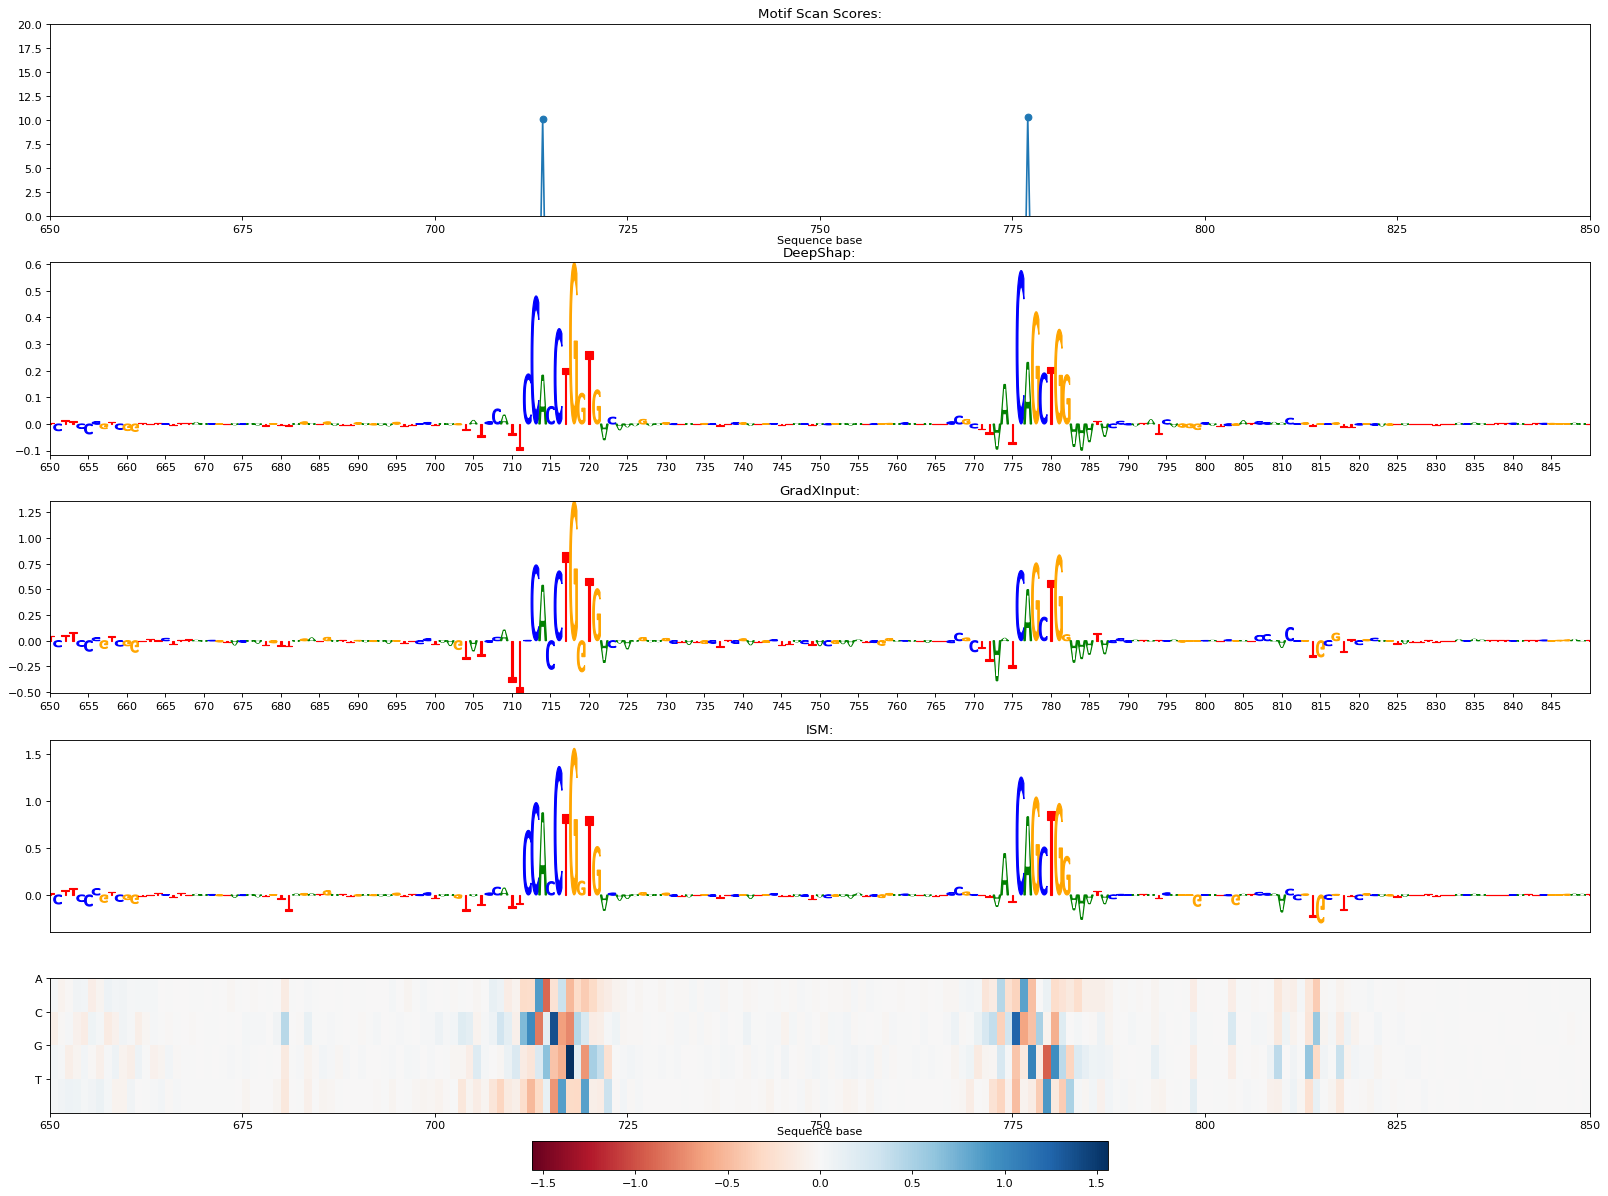

In [35]:
plot_all_interpretations([pos_interpretations],pos_X,xlim=(650,850))

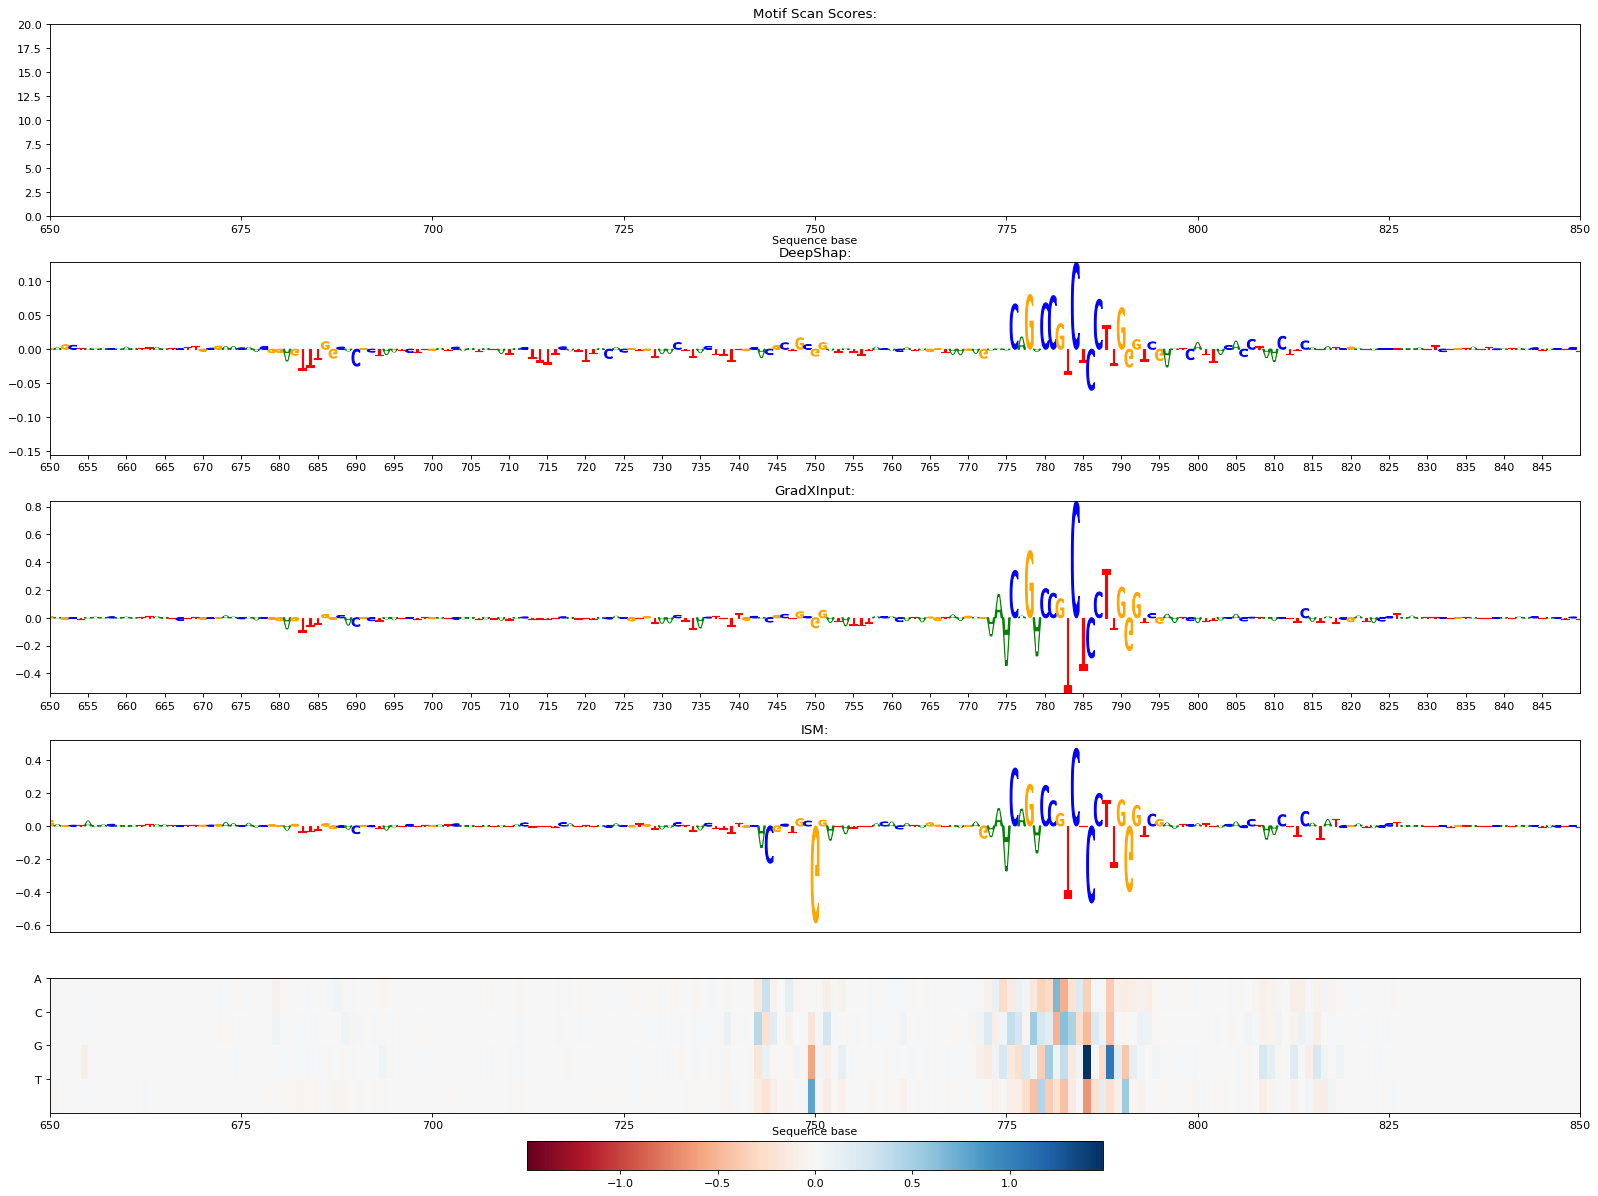

In [36]:
plot_all_interpretations([neg_interpretations],neg_X,xlim=(650,850))

As expected, dropout decreased the overfitting this model displayed previously and increased test performance.

## For further exploration<a name='11'>
<a href=#outline>Home</a>

In this tutorial we explored modeling of homotypic motif density. Other properties of regulatory DNA sequence include
![sequence properties 3](https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/sequence_properties_3.jpg?raw=1)
![sequence properties 4](https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/sequence_properties_4.jpg?raw=1)

DragoNN provides simulations that formulate learning these patterns into classification problems:
![sequence](https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/sequence_simulations.png?raw=1)

You can view the available simulation functions by running print_available_simulations:

In [19]:
print_available_simulations()

simulate_differential_accessibility
simulate_heterodimer_grammar
simulate_motif_counting
simulate_motif_density_localization
simulate_multi_motif_embedding
simulate_single_motif_detection
